In [1]:
import os
import math
import numpy as np
import tensorflow as tf
import cv2

slim = tf.contrib.slim
from tensorflow.contrib.slim.python.slim import queues

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as mpcm

In [3]:
import sys
sys.path.append('../')

In [4]:
from datasets import dataset_factory
from nets import nets_factory
from preprocessing import preprocessing_factory

In [5]:
isess = tf.InteractiveSession()

## Some drawing routines

In [6]:
def colors_subselect(colors, num_classes=21):
    dt = len(colors) // num_classes
    sub_colors = []
    for i in range(num_classes):
        color = colors[i*dt]
        if isinstance(color[0], float):
            sub_colors.append([int(c * 255) for c in color])
        else:
            sub_colors.append([c for c in color])
    return sub_colors

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """Draw a collection of lines on an image.
    """
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
def draw_rectangle(img, p1, p2, color=[255, 0, 0], thickness=2):
    cv2.rectangle(img, p1[::-1], p2[::-1], color, thickness)
    
    
def draw_bbox(img, bbox, shape, label, color=[255, 0, 0], thickness=2):
    p1 = (int(bbox[0] * shape[0]), int(bbox[1] * shape[1]))
    p2 = (int(bbox[2] * shape[0]), int(bbox[3] * shape[1]))
    cv2.rectangle(img, p1[::-1], p2[::-1], color, thickness)
    p1 = (p1[0]+15, p1[1])
    cv2.putText(img, str(label), p1[::-1], cv2.FONT_HERSHEY_DUPLEX, 0.5, color, 1)


def bboxes_draw_on_img(img, classes, scores, bboxes, colors, thickness=2):
    shape = img.shape
    for i in range(bboxes.shape[0]):
        bbox = bboxes[i]
        color = colors[classes[i]]
        # Draw bounding box...
        p1 = (int(bbox[0] * shape[0]), int(bbox[1] * shape[1]))
        p2 = (int(bbox[2] * shape[0]), int(bbox[3] * shape[1]))
        cv2.rectangle(img, p1[::-1], p2[::-1], color, thickness)
        # Draw text...
        s = '%s/%.3f' % (classes[i], scores[i])
        p1 = (p1[0]-5, p1[1])
        cv2.putText(img, s, p1[::-1], cv2.FONT_HERSHEY_DUPLEX, 0.4, color, 1)


In [7]:
colors = colors_subselect(mpcm.plasma.colors, num_classes=21)
colors_tableau = [(255, 255, 255), (31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
                 (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
                 (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
                 (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
                 (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

## Pascal VOC dataset

Check the Pascal VOC pipeline and associated TFRecords files.

In [8]:
from datasets import pascalvoc_2007
from datasets import pascalvoc_2012

DATASET_DIR = '/media/paul/DataExt4/PascalVOC/dataset/'
SPLIT_NAME = 'test'
BATCH_SIZE = 16

# Dataset provider loading data from the dataset.
dataset = pascalvoc_2007.get_split(SPLIT_NAME, DATASET_DIR)
provider = slim.dataset_data_provider.DatasetDataProvider(dataset, 
                                                          shuffle=False,
#                                                           num_epochs=1,
                                                          common_queue_capacity=2 * BATCH_SIZE,
                                                          common_queue_min=BATCH_SIZE)
[image, shape, bboxes, labels] = provider.get(['image', 'shape', 'object/bbox', 'object/label'])
print('Dataset:', dataset.data_sources, '|', dataset.num_samples)

Dataset: /media/paul/DataExt4/PascalVOC/dataset/voc_2007_test.tfrecord | 4952


In [9]:
# images = tf.train.batch(
#                 [image_crop],
#                 batch_size=BATCH_SIZE,
#                 num_threads=1,
#                 capacity=5 * BATCH_SIZE)

In [10]:
# Problem: image shape is not fully defined => random crop with deterministic size.
xy = tf.random_uniform((2, ), minval=0, maxval=shape[0] // 3, dtype=tf.int64)
image_crop = tf.slice(image, [0, 0, 0], [250, 250, 3])

print('Original vs crop:', image.get_shape(), image_crop.get_shape())

Original vs crop: (?, ?, 3) (250, 250, 3)


In [11]:
# with queues.QueueRunners(sess):
# Start populating queues.
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(coord=coord)

In [12]:
# Draw groundtruth bounding boxes using TF routine.
image_bboxes = tf.squeeze(tf.image.draw_bounding_boxes(tf.expand_dims(tf.to_float(image) / 255., 0), 
                                                       tf.expand_dims(bboxes, 0)))

Image shape: (500, 353, 3) [500 353   3]
Bounding boxes: [[ 0.47999999  0.13597734  0.74199998  0.55240792]
 [ 0.024       0.02266289  0.99599999  0.99716711]]
Labels: [12 15]


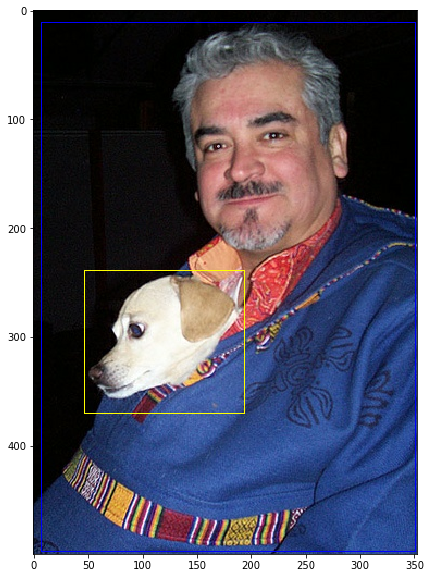

In [13]:
# Eval and display the image + bboxes.
rimg, rshape, rbboxes, rlabels = isess.run([image_bboxes, shape, bboxes, labels])

print('Image shape:', rimg.shape, rshape)
print('Bounding boxes:', rbboxes)
print('Labels:', rlabels)

fig = plt.figure(figsize = (10,10))
plt.imshow(rimg)

## Test SSD-300 model using TFRecords pipeline

Restore model and test it on some random images coming from Pascal TFRecords.

In [14]:
from nets import ssd_vgg_300
from nets import ssd_vgg_512
from nets import ssd_common

from preprocessing import ssd_vgg_preprocessing

ckpt_filename = '/media/paul/DataExt4/PascalVOC/training/ckpts/SSD_300x300_ft/ssd_300_vgg.ckpt'
# ckpt_filename = '/media/paul/DataExt4/PascalVOC/training/ckpts/SSD_512x512_ft/ssd_512_vgg.ckpt'
# ckpt_filename = '/home/paul/Development/Research/SSD-Tensorflow/logs/ssd_300_vgg_2/model.ckpt-148624'

In [15]:
# SSD object.
reuse = True if 'ssd' in locals() else None
params = ssd_vgg_300.SSDNet.default_params
ssd = ssd_vgg_300.SSDNet(params)

# Image pre-processimg
out_shape = ssd.params.img_shape
image_pre, labels_pre, bboxes_pre, bbox_img = \
    ssd_vgg_preprocessing.preprocess_for_eval(image, labels, bboxes, out_shape, 
                                              resize=ssd_vgg_preprocessing.Resize.CENTRAL_CROP)
image_4d = tf.expand_dims(image_pre, 0)

# SSD construction.
with slim.arg_scope(ssd.arg_scope(weight_decay=0.0005)):
    predictions, localisations, logits, end_points = ssd.net(image_4d, is_training=False, reuse=reuse)
    
# SSD default anchor boxes.
img_shape = out_shape
layers_anchors = ssd.anchors(img_shape, dtype=np.float32)

In [16]:
for k in sorted(end_points.keys()):
    print(k, end_points[k].get_shape())

block1 (1, 300, 300, 64)
block10 (1, 3, 3, 256)
block11 (1, 1, 1, 256)
block2 (1, 150, 150, 128)
block3 (1, 75, 75, 256)
block4 (1, 38, 38, 512)
block5 (1, 19, 19, 512)
block6 (1, 19, 19, 1024)
block7 (1, 19, 19, 1024)
block8 (1, 10, 10, 512)
block9 (1, 5, 5, 256)


In [17]:
# Targets encoding.
target_labels, target_localizations, target_scores = \
    ssd_common.tf_ssd_bboxes_encode(labels, bboxes_pre, layers_anchors, 
                                    num_classes=params.num_classes, no_annotation_label=params.no_annotation_label)

In [18]:
nms_threshold = 0.5

# Output decoding.
localisations = ssd.bboxes_decode(localisations, layers_anchors)
tclasses, tscores, tbboxes = ssd_common.tf_ssd_bboxes_select(predictions, localisations)
tclasses, tscores, tbboxes = ssd_common.tf_bboxes_sort(tclasses, tscores, tbboxes, top_k=400)
tclasses, tscores, tbboxes = ssd_common.tf_bboxes_nms_batch(tclasses, tscores, tbboxes,
                                                            nms_threshold=0.3, num_classes=ssd.params.num_classes)

In [19]:
# Initialize variables.
init_op = tf.global_variables_initializer()
isess.run(init_op)
# Restore SSD model.
saver = tf.train.Saver()
saver.restore(isess, ckpt_filename)

In [20]:
# Run model.
[rimg, rpredictions, rlocalisations, rclasses, rscores, rbboxes, glabels, gbboxes, rbbox_img, rt_labels, rt_localizations, rt_scores] = \
    isess.run([image_4d, predictions, localisations, tclasses, tscores, tbboxes,
               labels, bboxes_pre, bbox_img, 
               target_labels, target_localizations, target_scores])

In [21]:
def bboxes_select(classes, scores, bboxes, threshold=0.1):
    """Sort bounding boxes by decreasing order and keep only the top_k
    """
    mask = scores > threshold
    classes = classes[mask]
    scores = scores[mask]
    bboxes = bboxes[mask]
    return classes, scores, bboxes

print(rclasses, rscores)
print(rscores.shape)

rclasses, rscores, rbboxes = bboxes_select(rclasses, rscores, rbboxes, 0.1)
# print(list(zip(rclasses, rscores)))
# print(rbboxes)

[[19 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]] [[ 0.96111107  0.25165352  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.        ]]
(1, 50)


In [22]:
# # Compute classes and bboxes from the net outputs.
# rclasses, rscores, rbboxes,_,_ = ssd_common.ssd_bboxes_select(rpredictions, rlocalisations, layers_anchors,
#                                                                threshold=0.3, img_shape=img_shape, 
#                                                                num_classes=21, decode=True)
# rbboxes = ssd_common.bboxes_clip(rbbox_img, rbboxes)
# rclasses, rscores, rbboxes = ssd_common.bboxes_sort(rclasses, rscores, rbboxes, top_k=400, priority_inside=False)
# rclasses, rscores, rbboxes = ssd_common.bboxes_nms(rclasses, rscores, rbboxes, threshold=0.3)

Labels / scores: [(19, 0.96111107), (15, 0.25165352)]
Grountruth labels: [19]
[[ 0.33333334  0.40666667  0.67000002  0.63333333]]
[[ 0.31587347  0.35688621  0.65262425  0.68688625]
 [ 0.50752437  0.0685846   0.60651934  0.11808207]]


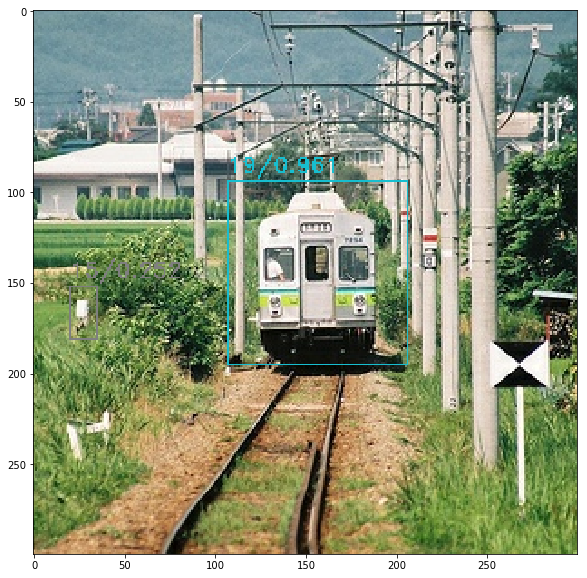

In [31]:
# Draw bboxes
img_bboxes = np.copy(ssd_vgg_preprocessing.np_image_unwhitened(rimg[0]))
bboxes_draw_on_img(img_bboxes, rclasses, rscores, rbboxes, colors_tableau, thickness=1)
# bboxes_draw_on_img(img_bboxes, glabels, np.zeros_like(glabels), gbboxes, colors_tableau, thickness=1)
# bboxes_draw_on_img(img_bboxes, test_labels, test_scores, test_bboxes, colors_tableau, thickness=1)

print('Labels / scores:', list(zip(rclasses, rscores)))
print('Grountruth labels:', list(glabels))
print(gbboxes)
print(rbboxes)

fig = plt.figure(figsize = (10,10))
plt.imshow(img_bboxes)

In [24]:
import tf_extended as tfe

isess.run(ssd_common.tf_bboxes_jaccard(gbboxes[0], rbboxes))

array([ 0.62896442,  0.        ], dtype=float32)

In [25]:
test_bboxes = []
test_labels = []
test_scores = []
for i in range(0, 3):
    yref, xref, href, wref = layers_anchors[i]
    ymin = yref - href / 2.
    xmin = xref - wref / 2.
    ymax = yref + href / 2.
    xmax = xref + wref / 2.
    bb = np.stack([ymin, xmin, ymax, xmax], axis=-1)
    
    idx = yref.shape[0] // 2
    idx = np.random.randint(yref.shape[0])
#     print(bb[idx, idx].shape)
    test_bboxes.append(bb[idx, idx])
    test_labels.append(np.ones(href.shape, dtype=np.int64) * i)
    test_scores.append(np.ones(href.shape))

test_bboxes = np.concatenate(test_bboxes)
test_labels = np.concatenate(test_labels)
test_scores = np.concatenate(test_scores)

print(test_bboxes.shape)
print(test_labels.shape)
print(test_scores.shape)


(16, 4)
(16,)
(16,)


In [26]:
rt_labels, rt_localizations, rt_scores
for i in range(len(rt_labels)):
    print(rt_labels[i].shape)
    idxes = np.where(rt_labels[i] > 0)
#     idxes = np.where(rt_scores[i] > 0.)
    print(idxes)
    print(rt_localizations[i][idxes])
    print(list(zip(rt_labels[i][idxes], rt_scores[i][idxes])))
    print()

(38, 38, 4)
(array([11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 1

In [27]:
# fig = plt.figure(figsize = (8,8))
# plt.imshow(ssd_preprocessing.np_image_unwhitened(rimg[0]))
# print('Ground truth labels: ', rlabels)

In [28]:
# Request threads to stop. Just to avoid error messages
# coord.request_stop()
# coord.join(threads)

In [29]:
PleaseStopHere;

NameError: name 'PleaseStopHere' is not defined

## Test SSD-300 model using sample images

Restore model and test it on some sample images.

In [ ]:
# Input placeholder.
net_shape = (300, 300)
img_input = tf.placeholder(tf.uint8, shape=(None, None, 3))
image_pre, labels_pre, bboxes_pre, bbox_img = ssd_preprocessing.preprocess_for_eval(
    img_input, labels, None, net_shape, resize=ssd_preprocessing.Resize.PAD_AND_RESIZE)
image_4d = tf.expand_dims(image_pre, 0)

# Re-define the model
reuse = True if 'ssd' in locals() else None
with slim.arg_scope(ssd.arg_scope(weight_decay=0.0005)):
    predictions, localisations, logits, end_points = ssd.net(image_4d, is_training=False, reuse=reuse)

In [ ]:
# Main processing routine.
def process_image(img, select_threshold=0.5, nms_threshold=0.35, net_shape=(300, 300)):
    # Run SSD network.
    rimg, rpredictions, rlocalisations, rbbox_img = isess.run([image_4d, predictions, localisations, bbox_img],
                                                              feed_dict={img_input: img})
    # Compute classes and bboxes from the net outputs.
    rclasses, rscores, rbboxes, rlayers, ridxes = ssd_common.ssd_bboxes_select(
            rpredictions, rlocalisations, layers_anchors,
            threshold=select_threshold, img_shape=net_shape, num_classes=21, decode=True)
#     print(list(zip(classes, scores)))
#     print(rlayers)
#     print(ridxes)
    
    rbboxes = ssd_common.bboxes_clip(rbbox_img, rbboxes)
    rclasses, rscores, rbboxes = ssd_common.bboxes_sort(rclasses, rscores, rbboxes, 
                                                        top_k=400, priority_inside=True, margin=0.0)
    rclasses, rscores, rbboxes = ssd_common.bboxes_nms(rclasses, rscores, rbboxes, threshold=nms_threshold)
    # Resize bboxes to original image shape.
    rbboxes = ssd_common.bboxes_resize(rbbox_img, rbboxes)
    return rclasses, rscores, rbboxes
    

In [ ]:
# Test on demo images.
path = '../demo/'
image_names = sorted(os.listdir(path))
img = mpimg.imread(path + image_names[-3])

rclasses, rscores, rbboxes =  process_image(img)

# Draw results.
img_bboxes = np.copy(img)
bboxes_draw_on_img(img_bboxes, rclasses, rscores, rbboxes, colors_tableau, thickness=2)

fig = plt.figure(figsize = (12, 12))
plt.imshow(img_bboxes)

In [ ]:
idxes = np.where(inside)
rscores[idxes]

## Some TensorFlow tests...

In [ ]:
a = tf.constant([[5.0, 2], [5.0, 2]])
b = tf.constant([5.0, 2])
c = a * b
d = tf.nn.l2_normalize(a, dim=1)
# We can just use 'c.eval()' without passing 'sess'
print(d.eval())

## A few tests on Caffe model files...

In [ ]:
from pprint import pprint

import caffe
import numpy as np
from caffe.proto import caffe_pb2

caffe_filename = '/media/paul/DataExt4/PascalVOC/training/ckpts/SSD_300x300_ft/ssd_300_vgg.caffemodel'
caffe_filename = '/media/paul/DataExt4/PascalVOC/training/ckpts/SSD_512x512_ft/ssd_512_vgg.caffemodel'

caffemodel_params = caffe_pb2.NetParameter()
caffemodel_str = open(caffe_filename, 'rb').read()
caffemodel_params.ParseFromString(caffemodel_str)

In [ ]:
layers = caffemodel_params.layer
names = [(i, l.name, l.type, l.blobs[0].shape.dim if len(l.blobs) else 0) for i, l in enumerate(layers)]
pprint(names)

In [ ]:
idx = 2
layer = layers[idx]
print(layer.type)
a = np.array(layer.blobs[0].data)
s = layer.blobs[0].shape.dim
print(s, 38*38)
# print(a)

In [ ]:
from nets import caffe_scope

In [ ]:
csc = caffe_scope.CaffeScope()

In [ ]:
d = {}
d[csc.conv_biases_init] = 0
d[csc.conv_biases_init] += 1

In [ ]:
min_dim = 300
mbox_source_layers = ['conv4_3', 'fc7', 'conv6_2', 'conv7_2', 'conv8_2', 'conv9_2']
min_ratio = 15
max_ratio = 90
step = int(math.floor((max_ratio - min_ratio) / (len(mbox_source_layers) - 2)))
min_sizes = []
max_sizes = []
for ratio in range(min_ratio, max_ratio + 1, step):
    min_sizes.append(min_dim * ratio / 100.)
    max_sizes.append(min_dim * (ratio + step) / 100.)
min_sizes = [min_dim * 7 / 100.] + min_sizes
max_sizes = [min_dim * 15 / 100.] + max_sizes

In [ ]:
print(min_sizes)
print(max_sizes)

In [ ]:
feat_shapes=[(38, 38), (19, 19), (10, 10), (5, 5), (3, 3), (1, 1)]

In [ ]:
steps = [8, 16, 32, 64, 100, 300]
offset = 0.5

In [ ]:
for i in range(len(steps)):
    print((feat_shapes[i][0] - offset) * steps[i] / 300, (feat_shapes[i][0] - offset) / feat_shapes[i][0])

In [ ]:
min_dim = 512
# conv4_3 ==> 64 x 64
# fc7 ==> 32 x 32
# conv6_2 ==> 16 x 16
# conv7_2 ==> 8 x 8
# conv8_2 ==> 4 x 4
# conv9_2 ==> 2 x 2
# conv10_2 ==> 1 x 1
mbox_source_layers = ['conv4_3', 'fc7', 'conv6_2', 'conv7_2', 'conv8_2', 'conv9_2', 'conv10_2']
# in percent %
min_ratio = 10
max_ratio = 90
step = int(math.floor((max_ratio - min_ratio) / (len(mbox_source_layers) - 2)))
min_sizes = []
max_sizes = []
for ratio in range(min_ratio, max_ratio + 1, step):
  min_sizes.append(min_dim * ratio / 100.)
  max_sizes.append(min_dim * (ratio + step) / 100.)
min_sizes = [min_dim * 4 / 100.] + min_sizes
max_sizes = [min_dim * 10 / 100.] + max_sizes
steps = [8, 16, 32, 64, 128, 256, 512]

In [ ]:
print(min_sizes)
print(max_sizes)

In [ ]:
pprint(list(zip(min_sizes, max_sizes)))